<br>

<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<hr>

# Sentinel-3 OLCI Level-1B Calibrated Radiances and SLSTR Level-1 TIR Brightness Temperature

### About
#### Ocean and Land Colour Imager (OLCI)
Sentinel-3 OLCI Level-1B data products are available as Full (`OL_1_EFR`) and Reduced Resolution (`OL_1_ERR`) data files. The following notebook shows you how `OL_1_EFR` calibrated radiance data are structured and how you can use them to generate true- and false-colour composite images.

Find more information on the OLCI data products in the [Sentinel-3 OLCI User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci).

#### Sea and Land Surface Temperature Radiometer (SLSTR)
The SLSTR Level-1B products for the thermal IR and fire channels (labelled as S7 to S9 and F1, F2 for fire channels) contain, for each view and for each channel, the full-resolution geolocated radiometric measurements, expressed as Top of Atmosphere (TOA) Brightness Temperatures (BT).

Find more information on the SLSTR data products in the [Sentinel-3 SLSTR User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr).

#### Case Event
This notebook provides an introduction to the Sentinel-3 OLCI and SLSTR data focusing on the [Washburn Fire](https://inciweb.nwcg.gov/incident/8209/) near Yosemite, California, USA that occurred in July 2022.

### Basic Facts

#### OLCI
> **Spatial resolution**: `300m` <br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**:  `Less than 2 days` <br>
> **Data availability**: `since 2016`

#### SLSTR
> **Spatial resolution**: `1km` <br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**:  `Less than 2 days` <br>
> **Data availability**: `since 2016`


### How to access the data

Sentinel-3 OLCI and SLSTR data can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home). You need to register for an account and login before downloading data. 

Sentinel-3 OLCI and SLSTR data products are disseminated as `.zip archives`, containing data files in `NetCDF` format.

The two data files to be explored in this notebooks are as follows:
* S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002
* S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004

You can copy and paste a file name into the search bar and click on the magnifying glass icon to search for the product. Click on the download URL in the result to begin downloading the file.

### Module Outline
* [1 - Load and browse Sentinel-3 OLCI Level-1B data](#olci_load_browse)
* [2 - Browse and visualize Sentinel-3 OLCI composite IDs](#olci_composites)
* [3 - Generate a geographical subset around northern California (300m)](#subset_300m)
* [4 - Visualize Sentinel-3 OLCI true colour composite with Cartopy features](#olci_vis)
* [5 - Load and browse Sentinel-3 SLSTR Brightness Temperature Level 1B data](#slstr_load_browse)
* [6 - Generate a geographical subset around northern California (1km)](#subset_1km)
* [7 - Visualize Sentinel-3 SLSTR Level-1B Brightness Temperature and OLCI Level-1B true color composite with Cartopy features](#slstr_vis)

<hr>

##### Load required libraries

In [1]:
import os
import xarray as xr
import numpy as np
import glob
from satpy.scene import Scene
from satpy import MultiScene
from satpy.writers import to_image
from satpy import find_files_and_readers

from datetime import datetime
import pyresample as prs

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
import logging
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
logging.basicConfig(level=logging.ERROR)

<hr>

## <a id='olci_load_browse'></a>1. Load and browse Sentinel-3 OLCI Level-1B data

Sentinel-3 Level-1B data are dissiminated as `.zip archives` when downloaded.

The first step is to unzip file from the zipped archive downloaded. 

In [2]:
import zipfile
with zipfile.ZipFile('../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.zip', 'r') as zip_ref:
    zip_ref.extractall('../../eodata/yosemite/sentinel3/olci/')

The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [3]:
olci_dir = '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[7])

Oa01_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa04_radiance.nc
Oa05_radiance.nc
Oa06_radiance.nc
Oa07_radiance.nc
Oa08_radiance.nc
Oa09_radiance.nc
Oa10_radiance.nc
Oa11_radiance.nc
Oa12_radiance.nc
Oa13_radiance.nc
Oa14_radiance.nc
Oa15_radiance.nc
Oa16_radiance.nc
Oa17_radiance.nc
Oa18_radiance.nc
Oa19_radiance.nc
Oa20_radiance.nc
Oa21_radiance.nc
geo_coordinates.nc
instrument_data.nc
qualityFlags.nc
removed_pixels.nc
tie_geo_coordinates.nc
tie_geometries.nc
tie_meteo.nc
time_coordinates.nc


You will use the Python library `satpy` to open the data. The results in a `netCDF4.Dataset`, which contains the dataset's metadata, dimension and variable information.

Read more about `satpy` [here](https://satpy.readthedocs.io/en/stable/).

Let us load the OLCI Level-1B calibrated radiance data. First, you specify the file path and create a variable with the name `file_name`. Each file contains data from a single band.

In [4]:
file_name = glob.glob(olci_dir+'*.nc')
file_name

['../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa01_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa02_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa03_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa04_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa05_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR____20220710T182040_20220710T182340_20220711T085512_0180_068_084_2340_PS2_O_NT_002.SEN3/Oa06_radiance.nc',
 '../../eodata/yosemite/sentinel3/olci/S3B_OL_1_EFR_

In a next step, you use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for Sentinel-3 OLCI Level-1B data, you can use the `olci_l1b` reader.

In [5]:
scn =Scene(filenames=file_name,reader='olci_l1b')

scn

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. 

In [6]:
scn.available_dataset_names()

['Oa01',
 'Oa02',
 'Oa03',
 'Oa04',
 'Oa05',
 'Oa06',
 'Oa07',
 'Oa08',
 'Oa09',
 'Oa10',
 'Oa11',
 'Oa12',
 'Oa13',
 'Oa14',
 'Oa15',
 'Oa16',
 'Oa17',
 'Oa18',
 'Oa19',
 'Oa20',
 'Oa21',
 'altitude',
 'humidity',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'sea_level_pressure',
 'solar_azimuth_angle',
 'solar_zenith_angle',
 'total_columnar_water_vapour',
 'total_ozone']

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `Oa08` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [7]:
scn.load(['Oa08'])
scn['Oa08']

<xarray.DataArray (y: 4091, x: 4865)>
dask.array<mul, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    units:                %
    platform_name:        Sentinel-3B
    sensor:               olci
    name:                 Oa08
    wavelength:           0.665 µm (0.66-0.67 µm)
    resolution:           300
    calibration:          reflectance
    modifiers:            ()
    start_time:           2022-07-10 18:20:40
    end_time:             2022-07-10 18:23:40
    reader:               olci_l1b
    area:                 Shape: (4091, 4865)\nLons: <xarray.DataArray 'longi...
    _satpy_id:            DataID(name='Oa08', wavelength=WavelengthRange(min=...
    ancillary_variables:  []

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [8]:
scn['Oa08'].attrs.keys()

dict_keys(['units', 'platform_name', 'sensor', 'name', 'wavelength', 'resolution', 'calibration', 'modifiers', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [9]:
scn['Oa08'].attrs['start_time'], scn['Oa08'].attrs['end_time']

(datetime.datetime(2022, 7, 10, 18, 20, 40),
 datetime.datetime(2022, 7, 10, 18, 23, 40))

## <a id='olci_composites'></a>2. Browse and visualize Sentinel-3 OLCI composite IDs

 composites combine three window channel of satellite data in order to get e.g. a true-color image of the scene. Depending on which channel combination is used, different features can be highlighted in the composite, e.g. dust. The satpy library offers several predefined composites options. The function `available_composite_ids()` returns a list of available composite IDs.

In [10]:
scn.available_composite_ids()

[DataID(name='ocean_color'),
 DataID(name='true_color'),
 DataID(name='true_color_desert'),
 DataID(name='true_color_land'),
 DataID(name='true_color_marine_clean'),
 DataID(name='true_color_marine_tropical'),
 DataID(name='true_color_raw')]

Let us define a list of containing a single composite ID, `true_color`. The fire which will be shown is the Washburn Fire which occurred near Yosemite in California, USA in July 2022.

This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [11]:
composite_id = ['true_color']
scn.load(composite_id, upper_right_corner='NE')

## <a id='subset_300m'></a>3. Generate a geographical subset around northern California (300m)

Let us generate a geographical subset around northern California and resample it to 300m, which is the resolution of the Sentinel-3 OLCI Level 1B data. You can do this with the function stored in the `coord2area_def.py` script which converts human coordinates (longitude and latitude) to an area definition. 

You need to define the following arguments: 
- `name` :the name of the area definition, set this to `california_300m`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `37`
- `max_lat`: the maximum latitude value, set this to `39`
- `min_lon`: the minimum longitude value, set this to `-121`
- `max_lon`: the maximum longitude value, set this to `-118`
- `resolution(km)`: the resolution in kilometres, set this to `0.3`

Afterwards, you can visualize the resampled image with the function `show()`.

In [12]:
%run coord2area_def.py california_1km laea 37 39 -121 -118 0.3

### +proj=laea +lat_0=38.0 +lon_0=-119.5 +ellps=WGS84

california_1km:
  description: california_1km
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 38.0
    lon_0: -119.5
  shape:
    height: 740
    width: 890
  area_extent:
    lower_left_xy: [-133512.036824, -109921.142307]
    upper_right_xy: [133512.036824, 112052.222445]


From the values generated by `coord2area_def.py`, you copy and paste several into the template below. 

You need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `'california_300m'`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `740`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `890`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-133512.036824, -109921.142307, 133512.036824, 112052.222445)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj`, e.g. `'+proj=laea +lat_0=38.25 +lon_0=-119.75 +ellps=WGS84'` 
- `description` (string): Give this a generic name for the region, such as `'California'`
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `'laea_38.0_-119.5'`

Next, use the area definition to resample the loaded Scene object. You will make use of the `get_area_def` function from the [pyresample](https://pyresample.readthedocs.io/en/latest/) library. 

You should end up with the following code block.

In [13]:
from pyresample import get_area_def

area_id = 'california_300m'

x_size = 740
y_size = 890
area_extent = (-133512.036824, -109921.142307, 133512.036824, 112052.222445)
projection = '+proj=laea +lat_0=38.0 +lon_0=-119.5 +ellps=WGS84'
description = "California"
proj_id = 'laea_38.0_-119.5'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

Next, use the area definition to resample the loaded Scene object.

In [14]:
scn_resample = scn.resample(areadef)

Afterwards, you can visualize the resampled image with the function `show()`.

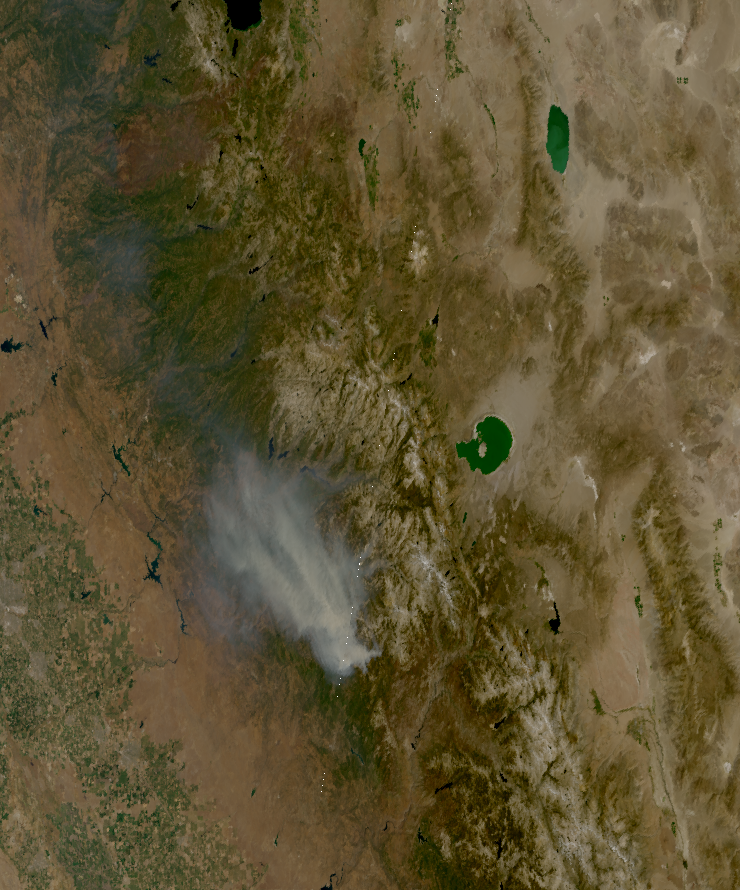

In [15]:
scn_resample.show('true_color')

## <a id='olci_vis'></a>4. Visualize Sentinel-3 OLCI true colour composite with Cartopy features

The satpy library's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, you will show you how you can visualize the true colour composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, you have to convert the `Scene` object into a numpy array. The numpy array additionally needs to be transposed to a shape that can be interpreted by matplotlib's function `imshow()`: (M,N,3). You can convert a Scene object into a `numpy.array` object with the function `np.asarray()`.

You can use the `.shape` method to see the shape of the numpy array. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`.

In [16]:
shape = np.asarray(scn_resample['true_color']).shape
shape

(3, 890, 740)

The shape of the array is `(3, 740, 890)`. This means you have to transpose the array and add index=0 on index position 3.

In [17]:
image = np.asarray(scn_resample['true_color']).transpose(1,2,0)

The next step is then to replace all nan values with 0. You can do this with the numpy function `nan_to_num()`. In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper percentiles so that a potential contrast decrease caused by outliers is eliminated.


In [18]:
image = np.nan_to_num(image)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

<br>

Let us now also define a variable for the `coordinate reference system`. You take the `area` attribute from the `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. You will use the `crs` information for plotting.

In [19]:
crs = scn_resample['true_color'].attrs['area'].to_cartopy_crs()

<br>

Now, you can visualise the true colour composite. The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

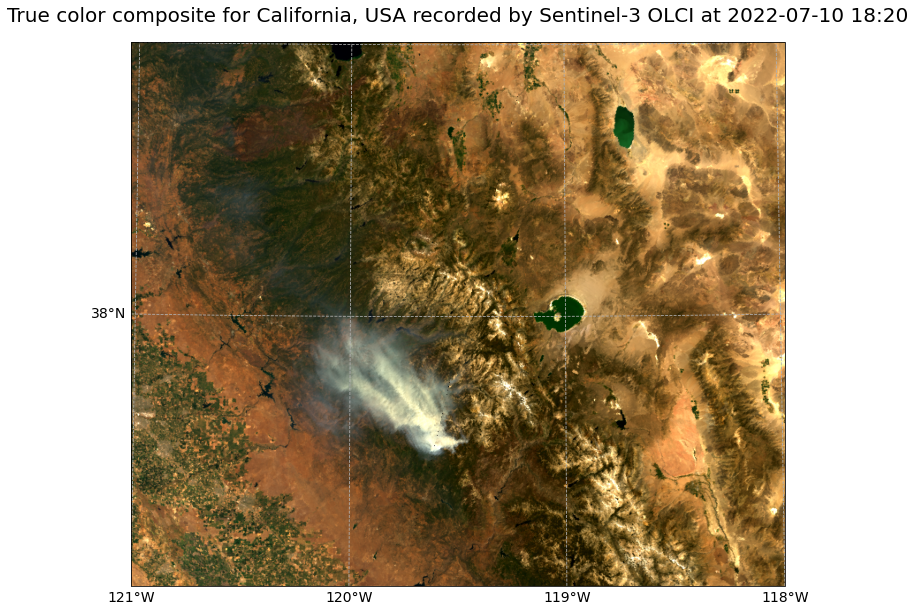

In [20]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Specify coastlines
ax.coastlines(resolution="10m", color="white")

# Specify a grid
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-140,-110,1), ylocs=range(20,50,1))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plot the numpy array with imshow()
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Set the title of the plot
plt.title("True color composite for California, USA recorded by Sentinel-3 OLCI at " + scn['Oa08'].attrs['start_time'].strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)

# Show the plot
plt.show()


## <a id='slstr_load_browse'></a>5. Load and browse Sentinel-3 SLSTR Brightness Temperature Level 1B data

The first step is to unzip file from the zipped archive downloaded. 

In [21]:
import zipfile
with zipfile.ZipFile('../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.zip', 'r') as zip_ref:
    zip_ref.extractall('../../eodata/yosemite/sentinel3/slstr/')

The unzipped folder contains 98 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 98 data files by looping through the data directory. You see that the channel information for Brightness Temperature follow the same naming and all contain `BT`.

According to [ESA](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-3-slstr/level-1/tir-brightness-temperature), the radiometric measurements are indexed according to the across track and along track direction on a 1 km grid. The brightness temperature associated with each image and orphan pixel, defined on the 1 km grid, is contained in a specific file named:

* S[7:9]_BT_in.nc for channels S7 to S9 and for nadir view
* S[7:9]_BT_io.nc for channels S7 to S9 and for oblique view
* F[1]_BT_fn/fo.nc for fire channels F1 for nadir or oblique view
* F[2]_BT_in/io.nc for fire channels F2 for nadir or oblique view

In [22]:
slstr_dir = '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/'
for i in glob.glob(slstr_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[7])

F1_BT_fn.nc
F1_BT_fo.nc
F1_quality_fn.nc
F1_quality_fo.nc
F2_BT_in.nc
F2_BT_io.nc
F2_quality_in.nc
F2_quality_io.nc
S1_quality_an.nc
S1_quality_ao.nc
S1_radiance_an.nc
S1_radiance_ao.nc
S2_quality_an.nc
S2_quality_ao.nc
S2_radiance_an.nc
S2_radiance_ao.nc
S3_quality_an.nc
S3_quality_ao.nc
S3_radiance_an.nc
S3_radiance_ao.nc
S4_quality_an.nc
S4_quality_ao.nc
S4_quality_bn.nc
S4_quality_bo.nc
S4_radiance_an.nc
S4_radiance_ao.nc
S4_radiance_bn.nc
S4_radiance_bo.nc
S5_quality_an.nc
S5_quality_ao.nc
S5_quality_bn.nc
S5_quality_bo.nc
S5_radiance_an.nc
S5_radiance_ao.nc
S5_radiance_bn.nc
S5_radiance_bo.nc
S6_quality_an.nc
S6_quality_ao.nc
S6_quality_bn.nc
S6_quality_bo.nc
S6_radiance_an.nc
S6_radiance_ao.nc
S6_radiance_bn.nc
S6_radiance_bo.nc
S7_BT_in.nc
S7_BT_io.nc
S7_quality_in.nc
S7_quality_io.nc
S8_BT_in.nc
S8_BT_io.nc
S8_quality_in.nc
S8_quality_io.nc
S9_BT_in.nc
S9_BT_io.nc
S9_quality_in.nc
S9_quality_io.nc
cartesian_an.nc
cartesian_ao.nc
cartesian_bn.nc
cartesian_bo.nc
cartesian_fn.nc


Let us load the Sentinel-3 Level 1B SLSTR data. First, you specify the file path and create a variable with the name `file_name2`. Let us add to a list all the files related to the F1 Brightness Temperature data at `nadir` view, which all end in `_fn`.

In [23]:
file_name2 = glob.glob(slstr_dir+'*_fn.nc')
file_name2

['../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/F1_BT_fn.nc',
 '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/F1_quality_fn.nc',
 '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/cartesian_fn.nc',
 '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/flags_fn.nc',
 '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/geodetic_fn.nc',
 '../../eodata/yosemite/sentinel3/slstr/S3B_SL_1_RBT____20220710T182040_20220710T182340_20220711T123743_0180_068_084_2340_PS2_O_NT_004.SEN3/indices_fn.nc']

In a next step, you use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for SLSTR Level-1B data, you can use the `slstr_l1b` reader.

In [24]:
scn2 =Scene(filenames=file_name2,reader='slstr_l1b')

scn2

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of MODIS, visit [this website](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/modis/).

In [25]:
scn2.available_dataset_names()

['F1',
 'F2',
 'S7',
 'S8',
 'S9',
 'bayes',
 'cloud',
 'confidence',
 'latitude',
 'longitude',
 'pointing']

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `F1` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [26]:
scn2.load(['F1'])
scn2['F1']

<xarray.DataArray 'F1_BT_fn' (y: 1200, x: 1500)>
dask.array<open_dataset-8e2c239962e50a05605202cf66656203F1_BT_fn, shape=(1200, 1500), dtype=float32, chunksize=(1200, 1500), chunktype=numpy.ndarray>
Coordinates:
    crs      object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes:
    name:                 F1
    sensor:               slstr
    wavelength:           3.74 µm (3.55-3.93 µm)
    resolution:           1000
    view:                 nadir
    stripe:               f
    calibration:          brightness_temperature
    coordinates:          ('longitude', 'latitude')
    file_type:            esa_l1b_tir
    standard_name:        toa_brightness_temperature
    units:                K
    modifiers:            ()
    long_name:            Gridded pixel brightness temperature for channel F1...
    platform_name:        Sentinel-3B
    start_time:           2022-07-10 18:20:39.922571
    end_time:             2022-07-10 18:23:39.616090
    reader:               slstr_l1b
    area:                 Shape: (1200, 1500)\nLons: <xarray.DataArray 'longi...
    _satpy_id:            DataID(name='F1', wavelength=WavelengthRange(min=3....
    ancillary_variables:  []

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [27]:
scn2['F1'].attrs.keys()

dict_keys(['name', 'sensor', 'wavelength', 'resolution', 'view', 'stripe', 'calibration', 'coordinates', 'file_type', 'standard_name', 'units', 'modifiers', 'long_name', 'platform_name', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [28]:
scn2['F1'].attrs['start_time'], scn2['F1'].attrs['end_time']

(datetime.datetime(2022, 7, 10, 18, 20, 39, 922571),
 datetime.datetime(2022, 7, 10, 18, 23, 39, 616090))

## <a id='subset_1km'></a>6. Generate a geographical subset around northern California (1km)

Let us generate a geographical subset around northern California and resample it to 1km, which is the resolution of the Sentinel-3 SLSTR Level 1B data. You can do this with the function stored in the `coord2area_def.py` script which converts human coordinates (longitude and latitude) to an area definition. 

You need to define the following arguments: 
- `name` :the name of the area definition, set this to `california_1km`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `37`
- `max_lat`: the maximum latitude value, set this to `39`
- `min_lon`: the minimum longitude value, set this to `-121`
- `max_lon`: the maximum longitude value, set this to `-118`
- `resolution(km)`: the resolution in kilometres, set this to `1`

Afterwards, you can visualize the resampled image with the function `show()`.

In [29]:
%run coord2area_def.py california_1km laea 37 39 -121 -118 1

### +proj=laea +lat_0=38.0 +lon_0=-119.5 +ellps=WGS84

california_1km:
  description: california_1km
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 38.0
    lon_0: -119.5
  shape:
    height: 222
    width: 267
  area_extent:
    lower_left_xy: [-133512.036824, -109921.142307]
    upper_right_xy: [133512.036824, 112052.222445]


From the values generated by `coord2area_def.py`, you copy and paste several into the template below. 

You need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `'california_1km'`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `267`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `222`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-133512.036824, -109921.142307, 133512.036824, 112052.222445)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj`, e.g. `'+proj=laea +lat_0=38.0 +lon_0=-119.5 +ellps=WGS84'` 
- `description` (string): Give this a generic name for the region, such as `'California'`
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `'laea_38.0_-119.5'`

Next, use the area definition to resample the loaded Scene object. You will make use of the `get_area_def` function from the [pyresample](https://pyresample.readthedocs.io/en/latest/) library. 

You should end up with the following code block.

In [30]:
from pyresample import get_area_def

area_id2 = 'california_1km'

x_size2 = 267
y_size2 = 222
area_extent2 = (-133512.036824, -109921.142307, 133512.036824, 112052.222445)
projection2 = '+proj=laea +lat_0=38.0 +lon_0=-119.5 +ellps=WGS84'
description2 = "California"
proj_id2 = 'laea_38.0_-119.5'

areadef_1km = get_area_def(area_id2, description2, proj_id2, projection2,x_size2, y_size2, area_extent2)

Next, use the area definition to resample the loaded Scene object.

In [31]:
scn_resample2 = scn2.resample(areadef_1km)

Next, use the area definition to resample the loaded Scene object.

Afterwards, you can visualize the resampled image with the function `show()`.

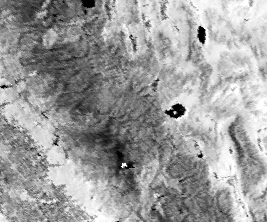

In [32]:
scn_resample2.show('F1')

<br>

## <a id='slstr_vis'></a>7. Visualize Sentinel-3 SLSTR Level-1B Brightness Temperature and OLCI Level-1B true color composite with Cartopy features

The satpy library's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, you will show you how you can visualize the true colour composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, you have to convert the `Scene` object into a numpy array. 

In [33]:
image2 = np.array(scn_resample2['F1'])

The next step is then to replace all nan values with 0. You can do this with the numpy function `nan_to_num()`.


In [34]:
image2 = np.nan_to_num(image2)
image2

array([[313.91   , 312.64   , 312.64   , ..., 330.06   , 329.83002,
        329.75   ],
       [316.48   , 312.07   , 312.03   , ..., 330.21002, 330.12   ,
        330.67   ],
       [311.07   , 314.09   , 311.75   , ..., 330.6    , 330.91   ,
        330.67   ],
       ...,
       [329.82   , 330.11002, 327.97   , ..., 310.92   , 306.77002,
        307.53   ],
       [329.76   , 329.65002, 329.03   , ..., 312.99002, 306.31   ,
        310.05002],
       [330.75   , 329.99002, 329.99002, ..., 311.34   , 311.92   ,
        313.16   ]], dtype=float32)

In a subsequent step, you then mask out all pixels with a Brightness Temperature values lower than 340 K.

In [35]:
image2 = np.where(image2 <= 340, np.nan, image2)
image2

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

Let us now also define a variable for the `coordinate reference system`. You take the `area` attribute from she `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. You will use the `crs` information for plotting.

In [36]:
# Now you can "copy" the coordinate reference system from the FRP data
crs2 = scn_resample2['F1'].attrs["area"].to_cartopy_crs()

You can make use of the `ListedColorMap` function from the matplotlib library to define the colors for each fire radiative power (FRP) class.

In [37]:
cm = ListedColormap([[1., 140./255., 0],
                     [178./255., 34./255., 34./255.],
                     [1, 0, 0]])

You can define the levels for the respective FRP classes in a list stored in the variable `bounds`. You can also use the `.BoundaryNorm()` function from `matplotlib.colors` to define the norm that you will use for plotting later. 

In [38]:
bounds = [340, 360, 380, 400]
norm = BoundaryNorm(bounds, cm.N)

Finally, let's try to plot the Sentinel-3 OLCI Level 1B composite and the Sentinel-3 SLSTR Level-1B Brightness Temperature data together.

The plotting code can be divided in five main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, US states and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

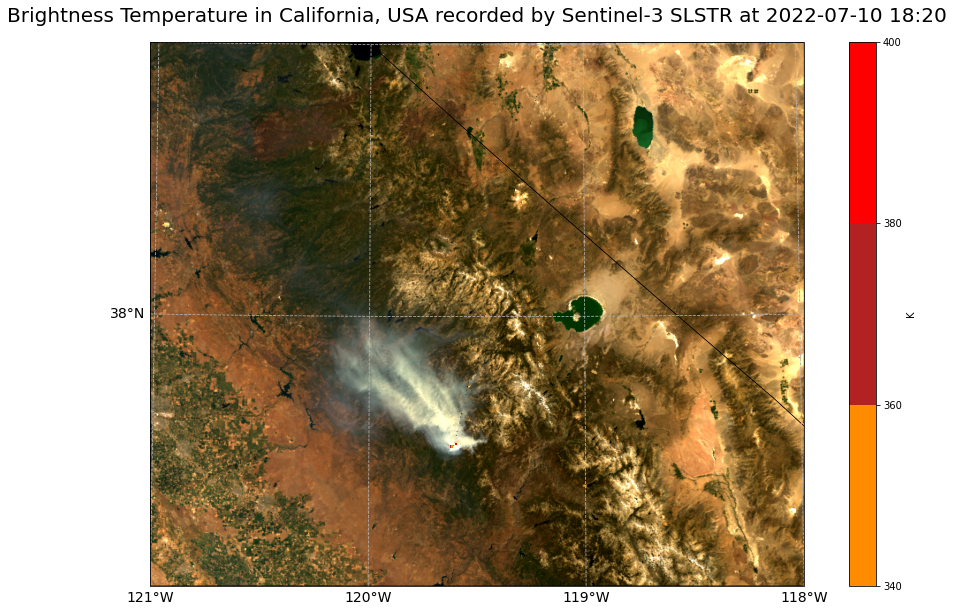

In [39]:
# Initiate a matplotlib figure using the coordinate reference system of the Level 1B data
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Specify coastlines
ax.coastlines(resolution="10m", color="white")

# Specify the US States
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

# Specify a grid
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-125,-110,1), ylocs=range(35,40,1))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plot the image data from the Level 1B true colour composite
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Plot the image data from the Level 2 FRP data
plt.imshow(image2, transform=crs2, extent=crs2.bounds, origin="upper", cmap=cm, norm=norm)

# Add a colour bar and set the label of the units to M W or megawatts
cbar = plt.colorbar(cmap=cm, norm=norm, boundaries=bounds)
cbar.set_label("K")

# Set the title of the plot
plt.title("Brightness Temperature in California, USA recorded by Sentinel-3 SLSTR at " + scn2['F1'].attrs['start_time'].strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)

# Show the plot
plt.show()

<hr>

### References
* Copernicus Sentinel data 2022

* Some code in this notebook was adapted from the following sources:
    * origin: https://python-kurs.github.io/sommersemester_2019/units/S01E07.html
    * copyright: 2019, Marburg University
    * license: CC BY-SA 4.0
    * retrieved: 2022-06-28 by Sabrina Szeto

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">GPL-3.0 License</a> and is developed under a Copernicus contract.